For this exercise, we'll need several things from `sklearn`:

In [0]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

We'll also need three other modules: `pandas`, `plotnine`, `sqlite3`.

In [0]:
import pandas as pd
import plotnine as p9
import sqlite3

Run the following cell.

It copies a database file called `friday.db` from the web into the file system hosting this notebook. This data is modified from that used in [Smith et al, 1988](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/).

In [0]:
!wget https://github.com/YCMI/summer-course-2020/raw/master/friday.db

--2020-06-12 06:57:56--  https://github.com/YCMI/summer-course-2020/raw/master/friday.db
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YCMI/summer-course-2020/master/friday.db [following]
--2020-06-12 06:57:56--  https://raw.githubusercontent.com/YCMI/summer-course-2020/master/friday.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172032 (168K) [application/octet-stream]
Saving to: ‘friday.db.1’

friday.db.1         100%[===================>] 168.00K  --.-KB/s    in 0.03s   

2020-06-12 06:57:56 (6.55 MB/s) - ‘friday.db.1’ saved [172032/172032]



The database contains three tables, with columns as below:

**demographics**: patient_id, dob, gender, children, state

**patienthistory**: patient_id, diabetespedigree, diagnoses

**testresults**: patient_id, diastolic, systolic, bicepskinthickness, seruminsulin, glucose, bmi


Connect to the `friday.db` database and look at a sample of each table to see how the data is structured.

In [0]:
conn = sqlite3.connect('friday.db')
demographics = pd.read_sql('SELECT * from demographics', conn)
demographics

,patient_id,dob,gender,children,state
0,20935,"Sep 01, 1973",F,1,Rhode Island
1,26574,"Nov 07, 1994",F,3,Massachussetts
2,12718,"Aug 01, 1998",F,1,New York
3,36959,"Aug 20, 1996",F,0,Connecticut
4,92337,"Jun 01, 1992",F,3,Rhode Island
...,...,...,...,...,...
1463,66247,"Jan 30, 1979",F,10,Massachussetts
1464,27385,"Jul 19, 1998",M,0,Massachussetts
1465,14989,"Oct 07, 1968",F,2,Massachussetts
1466,86520,"May 02, 1987",M,0,New York


In [0]:
pd.read_sql('SELECT * from patienthistory', conn)

,patient_id,diabetespedigree,diagnoses
0,20935,0.349,"Diabetes, Cancer, Influenza"
1,26574,0.279,Influenza
2,12718,1.394,"Diabetes, Influenza"
3,36959,0.431,Diabetes
4,92337,0.268,"Diabetes, Influenza, Depression"
...,...,...,...
1463,66247,0.205,Diabetes
1464,27385,0.355,"Diabetes, Influenza"
1465,14989,0.259,"Diabetes, Arthritis, Influenza, Depression"
1466,86520,1.162,Cancer


In [0]:
pd.read_sql('SELECT * from testresults', conn)

,patient_id,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi
0,20935,60,NaN,3.3 cm,156,126,30.1
1,26574,62,NaN,19 mm,74,99,21.8
2,12718,76,NaN,4.3 cm,210,199,42.9
3,36959,65,91.214016,26 mm,130,140,42.6
4,92337,70,NaN,18 mm,105,163,31.6
...,...,...,...,...,...,...,...
1463,66247,70,NaN,26 mm,115,125,31.1
1464,27385,72,NaN,32 mm,159,147,31.2
1465,14989,80,NaN,25 mm,210,108,27.0
1466,86520,84,112.768350,22 mm,200,167,29.3


Make a bar chart comparing the number of male and female patients per state in our dataset.

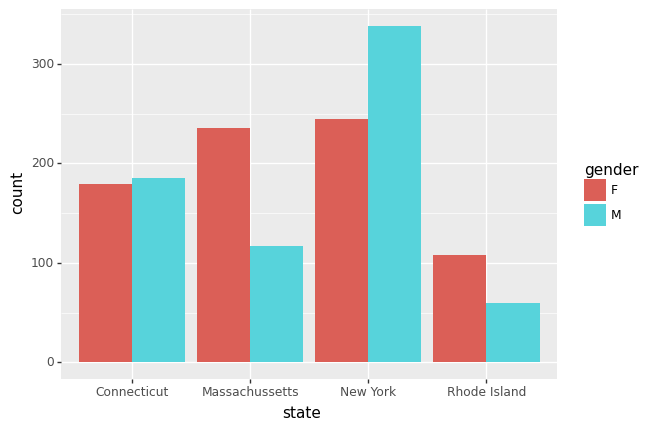

<ggplot: (8788884189844)>

In [0]:
p9.ggplot(demographics, p9.aes(x='state', fill='gender')) + p9.geom_bar(position='dodge')

We wish to test the hypotheses that for women, age, number of children, diabetespedigree (family history), blood pressure, serum insulin, glucose levels, and BMI are predictive of whether or not they have diabetes.

Use SQL to get a DataFrame of just the females with information on their: dob, number of children, diabetespedigree, diagnoses, diastolic, systolic, bicepskinthickness, seruminsulin, glucose, and bmi.

In [0]:
data = pd.read_sql('''
  SELECT dob, children, diabetespedigree, diagnoses, diastolic, systolic, bicepskinthickness, seruminsulin, glucose, bmi
  FROM demographics
  INNER JOIN patienthistory ON demographics.patient_id = patienthistory.patient_id
  INNER JOIN testresults on testresults.patient_id = demographics.patient_id
  WHERE gender='F'
''', conn)

data

,dob,children,diabetespedigree,diagnoses,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi
0,"Sep 01, 1973",1,0.349,"Diabetes, Cancer, Influenza",60,NaN,3.3 cm,156,126,30.1
1,"Nov 07, 1994",3,0.279,Influenza,62,NaN,19 mm,74,99,21.8
2,"Aug 01, 1998",1,1.394,"Diabetes, Influenza",76,NaN,4.3 cm,210,199,42.9
3,"Aug 20, 1996",0,0.431,Diabetes,65,91.214016,26 mm,130,140,42.6
4,"Jun 01, 1992",3,0.268,"Diabetes, Influenza, Depression",70,NaN,18 mm,105,163,31.6
...,...,...,...,...,...,...,...,...,...,...
763,"Jan 11, 1998",2,0.525,Influenza,62,117.558697,19 mm,100,91,27.3
764,"Jul 14, 1999",1,0.559,,24,NaN,1.9 cm,25,89,27.8
765,"Jan 30, 1979",10,0.205,Diabetes,70,NaN,26 mm,115,125,31.1
766,"Oct 07, 1968",2,0.259,"Diabetes, Arthritis, Influenza, Depression",80,NaN,25 mm,210,108,27.0


Let's clean up this data a bit.

Create a new column `age` and estimate it from the date of birth by assuming that every year has exactly 365.25 days.

Hint: You'll want to subtract dates and divide by `pd.to_timedelta('365.25 days')`

In [0]:
data['age'] = (pd.to_datetime('June 12, 2020') - pd.to_datetime(data['dob'])) / pd.to_timedelta('365.25 days')
data

,dob,children,diabetespedigree,diagnoses,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi,age
0,"Sep 01, 1973",1,0.349,"Diabetes, Cancer, Influenza",60,NaN,3.3 cm,156,126,30.1,46.778919
1,"Nov 07, 1994",3,0.279,Influenza,62,NaN,19 mm,74,99,21.8,25.596167
2,"Aug 01, 1998",1,1.394,"Diabetes, Influenza",76,NaN,4.3 cm,210,199,42.9,21.864476
3,"Aug 20, 1996",0,0.431,Diabetes,65,91.214016,26 mm,130,140,42.6,23.811088
4,"Jun 01, 1992",3,0.268,"Diabetes, Influenza, Depression",70,NaN,18 mm,105,163,31.6,28.030116
...,...,...,...,...,...,...,...,...,...,...,...
763,"Jan 11, 1998",2,0.525,Influenza,62,117.558697,19 mm,100,91,27.3,22.417522
764,"Jul 14, 1999",1,0.559,,24,NaN,1.9 cm,25,89,27.8,20.914442
765,"Jan 30, 1979",10,0.205,Diabetes,70,NaN,26 mm,115,125,31.1,41.366188
766,"Oct 07, 1968",2,0.259,"Diabetes, Arthritis, Influenza, Depression",80,NaN,25 mm,210,108,27.0,51.679671


Derive a new column `has_diabetes` (with `True` or `False` values) based on the `diagnoses` column.

Hint: you can do this in one line.

In [0]:
data['has_diabetes'] = data['diagnoses'].str.contains('Diabetes')
data

,dob,children,diabetespedigree,diagnoses,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi,age,has_diabetes
0,"Sep 01, 1973",1,0.349,"Diabetes, Cancer, Influenza",60,NaN,3.3 cm,156,126,30.1,46.778919,True
1,"Nov 07, 1994",3,0.279,Influenza,62,NaN,19 mm,74,99,21.8,25.596167,False
2,"Aug 01, 1998",1,1.394,"Diabetes, Influenza",76,NaN,4.3 cm,210,199,42.9,21.864476,True
3,"Aug 20, 1996",0,0.431,Diabetes,65,91.214016,26 mm,130,140,42.6,23.811088,True
4,"Jun 01, 1992",3,0.268,"Diabetes, Influenza, Depression",70,NaN,18 mm,105,163,31.6,28.030116,True
...,...,...,...,...,...,...,...,...,...,...,...,...
763,"Jan 11, 1998",2,0.525,Influenza,62,117.558697,19 mm,100,91,27.3,22.417522,False
764,"Jul 14, 1999",1,0.559,,24,NaN,1.9 cm,25,89,27.8,20.914442,False
765,"Jan 30, 1979",10,0.205,Diabetes,70,NaN,26 mm,115,125,31.1,41.366188,True
766,"Oct 07, 1968",2,0.259,"Diabetes, Arthritis, Influenza, Depression",80,NaN,25 mm,210,108,27.0,51.679671,True


The `bicepskinthickness` column has values with two different units -- cm and mm. Standardize this into a new column `bicepskinthickness_cm` measured in cm without units.

Hints: you could do this with the `re` module, but you don't need it. You'll also want a for loop, and an if statement to build the new column one entry at a time, although you can. You can convert a string `my_numstr` to a number using e.g. `my_num = float(my_numstr)`

In [0]:
bicepskinthickness_cm = []
for thickness in data['bicepskinthickness']:
  num, units = thickness.split()
  num = float(num)
  if units == 'mm':
    num = num / 10
  else:
    if units != 'cm':
      print('unsupported unit')
  bicepskinthickness_cm.append(num)

data['bicepskinthickness_cm'] = bicepskinthickness_cm
data
  

,dob,children,diabetespedigree,diagnoses,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi,age,has_diabetes,bicepskinthickness_cm
0,"Sep 01, 1973",1,0.349,"Diabetes, Cancer, Influenza",60,NaN,3.3 cm,156,126,30.1,46.778919,True,3.3
1,"Nov 07, 1994",3,0.279,Influenza,62,NaN,19 mm,74,99,21.8,25.596167,False,1.9
2,"Aug 01, 1998",1,1.394,"Diabetes, Influenza",76,NaN,4.3 cm,210,199,42.9,21.864476,True,4.3
3,"Aug 20, 1996",0,0.431,Diabetes,65,91.214016,26 mm,130,140,42.6,23.811088,True,2.6
4,"Jun 01, 1992",3,0.268,"Diabetes, Influenza, Depression",70,NaN,18 mm,105,163,31.6,28.030116,True,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,"Jan 11, 1998",2,0.525,Influenza,62,117.558697,19 mm,100,91,27.3,22.417522,False,1.9
764,"Jul 14, 1999",1,0.559,,24,NaN,1.9 cm,25,89,27.8,20.914442,False,1.9
765,"Jan 30, 1979",10,0.205,Diabetes,70,NaN,26 mm,115,125,31.1,41.366188,True,2.6
766,"Oct 07, 1968",2,0.259,"Diabetes, Arthritis, Influenza, Depression",80,NaN,25 mm,210,108,27.0,51.679671,True,2.5


Are any of the columns missing data? Are they missing a little data or a lot of data? Should we keep the column(s) with missing data?

In [0]:
data.isnull().describe()
# we see everything has no null entries EXCEPT systolic blood pressure, where
# the majority are missing. Safe to drop the column so let's do it

,dob,children,diabetespedigree,diagnoses,diastolic,systolic,bicepskinthickness,seruminsulin,glucose,bmi,age,has_diabetes,bicepskinthickness_cm
count,768,768,768,768,768,768,768,768,768,768,768,768,768
unique,1,1,1,1,1,2,1,1,1,1,1,1,1
top,False,False,False,False,False,True,False,False,False,False,False,False,False
freq,768,768,768,768,768,538,768,768,768,768,768,768,768


In [0]:
data = data.drop(['systolic'], axis=1)

While we're at it, drop the redundant columns: `dob`, `diagnoses`, and `bicepskinthickness`

In [0]:
data = data.drop(['dob', 'diagnoses', 'bicepskinthickness'], axis=1)

In [0]:
data

,children,diabetespedigree,diastolic,seruminsulin,glucose,bmi,age,has_diabetes,bicepskinthickness_cm
0,1,0.349,60,156,126,30.1,46.778919,True,3.3
1,3,0.279,62,74,99,21.8,25.596167,False,1.9
2,1,1.394,76,210,199,42.9,21.864476,True,4.3
3,0,0.431,65,130,140,42.6,23.811088,True,2.6
4,3,0.268,70,105,163,31.6,28.030116,True,1.8
...,...,...,...,...,...,...,...,...,...
763,2,0.525,62,100,91,27.3,22.417522,False,1.9
764,1,0.559,24,25,89,27.8,20.914442,False,1.9
765,10,0.205,70,115,125,31.1,41.366188,True,2.6
766,2,0.259,80,210,108,27.0,51.679671,True,2.5


Standardize your numeric data (should be everything except the `has_diabetes` column) to have a mean of 0 and a standard deviation of 1.

Hint: You can do this with simple arithmetic operations as we did on Wednesday or use a `StandardScaler` as you learned yesterday. The arithmetic solution can be done in two lines.

In [0]:
for column in ['children', 'diabetespedigree', 'diastolic', 'seruminsulin', 'glucose', 'bmi', 'age', 'bicepskinthickness_cm']:
  data[column] = (data[column] - data[column].mean()) / data[column].std()
data

,children,diabetespedigree,diastolic,seruminsulin,glucose,bmi,age,has_diabetes,bicepskinthickness_cm
0,-0.844335,-0.370859,-0.996820,-0.032535,0.141409,-0.343023,1.148553,True,0.324495
1,-0.250789,-0.582130,-0.835836,-0.715733,-0.745274,-1.540942,-0.651847,False,-0.990608
2,-0.844335,2.783109,0.291049,0.417376,2.538737,1.504372,-0.969017,True,1.263854
3,-1.141108,-0.123371,-0.594361,-0.249159,0.601171,1.461073,-0.803567,True,-0.333057
4,-0.250789,-0.615330,-0.191902,-0.457451,1.356493,-0.126531,-0.444977,True,-1.084544
...,...,...,...,...,...,...,...,...,...
763,-0.547562,0.160335,-0.835836,-0.499109,-1.007995,-0.747140,-0.922011,False,-0.990608
764,-0.844335,0.262953,-3.894525,-1.123985,-1.073675,-0.674976,-1.049764,False,-0.990608
765,1.826623,-0.805473,-0.191902,-0.374134,0.108569,-0.198695,0.688505,True,-0.333057
766,-0.547562,-0.642493,0.613016,0.417376,-0.449713,-0.790438,1.565086,True,-0.426993


### PCA

A good starting place when looking at a new dataset is running PCA and visualizing at a couple of the first principle components.

Remember, PCA is simply a rotation of our data that allows us to visualize the axis with the greatest variation. This can elucidate some separation in our data if it exists on those axis, but it may not. 

**Adapt yesterday's PCA code to work with today's data and visualize the data in PCA space. Color-code by `has_diabetes`.** (For concreteness, plot all possible pairs from the first three principal components... that is, show three graphs PC1-PC2, PC1-PC3, and PC2-PC3.)

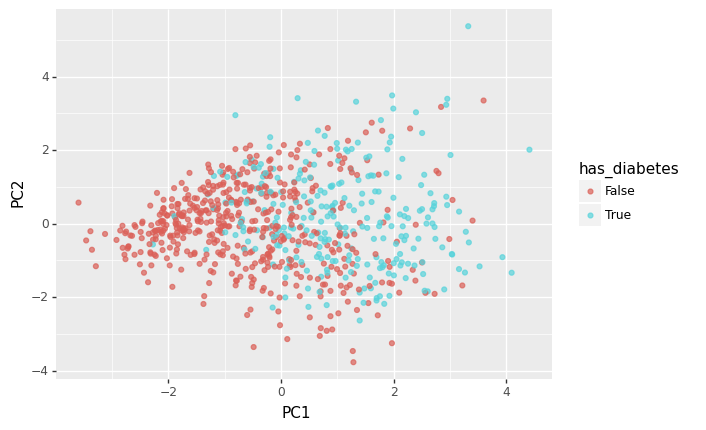

<ggplot: (8788880516209)>

In [0]:
y = data['has_diabetes']
X = data.drop(['has_diabetes'], axis=1)

pca = decomposition.PCA(n_components=3)
X_reduced = pd.DataFrame(
    pca.fit_transform(X),
    columns=['PC1', 'PC2', 'PC3']
)
X_reduced['has_diabetes'] = y

p9.ggplot(X_reduced, p9.aes(x='PC1', y='PC2', color='has_diabetes')) + p9.geom_point(alpha=0.7)



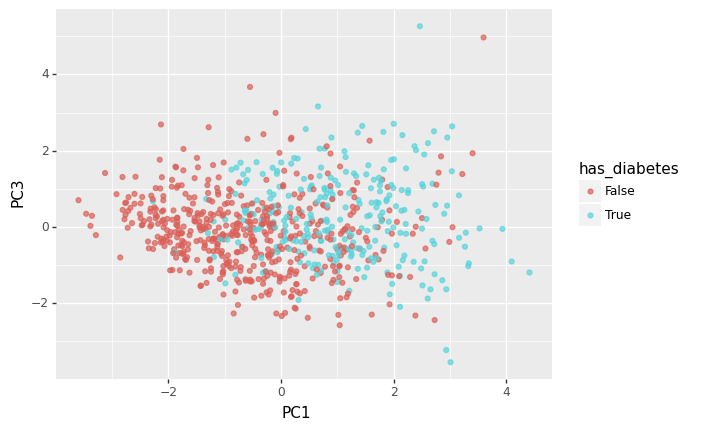

<ggplot: (-9223363247974272501)>

In [0]:
p9.ggplot(X_reduced, p9.aes(x='PC1', y='PC3', color='has_diabetes')) + p9.geom_point(alpha=0.7)


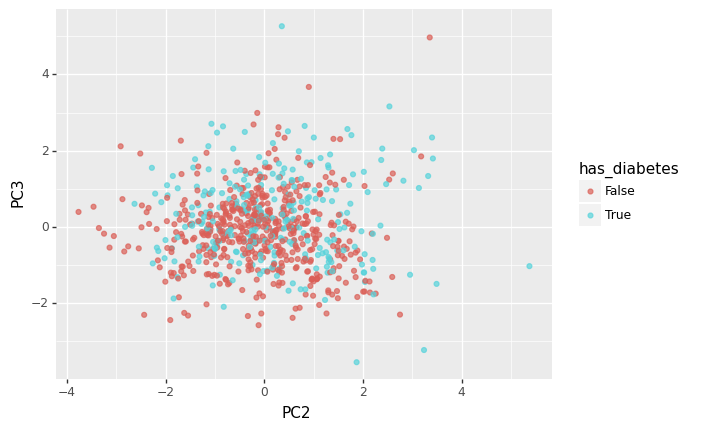

<ggplot: (8788880449800)>

In [0]:
p9.ggplot(X_reduced, p9.aes(x='PC2', y='PC3', color='has_diabetes')) + p9.geom_point(alpha=0.7)



What do you make of the graphs?

# Training and testing sets

Split your data into training and test sets with 20% of the data being used for the test set. To ensure we all work with the same random split, let's specify a `random_state`, namely `random_state=42`.

If your predictor variables are in `X` and your outcome vector is in `y`, this can be done using:

```
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

Hint: how can you split your DataFrame into a predictor matrix `X` and outcome vector `y`?

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cross-validation

Using 5-fold cross-validation (`cross_val_score`) on your *training* data only, plot the relationship between the number of estimators (between 10 and 100 counting by 10s) with a max depth of 4 and the average regression score for a corresponding `RandomForest`.

Hint: you did cross-validation yesterday in the disease classification exercises with logistic regression.

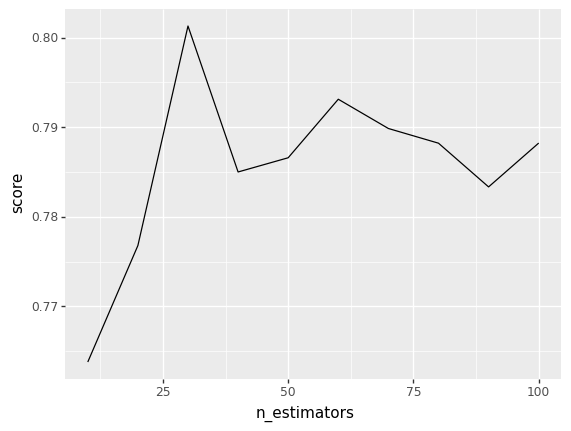

<ggplot: (-9223363247975960106)>

In [0]:
# performance of random forest, iterating number of estimators
scores = []
# number of estimators
N = 110
# maximum depth
D = 4
estimator_choices = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for n_estimators in estimator_choices:
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=D, random_state=0)
    # 5-fold cross validation
    sc = cross_val_score(clf, X_train, y_train, cv=5)
    scores.append(sc.mean())

(
    p9.ggplot(
      pd.DataFrame({'n_estimators': estimator_choices, 'score': scores}),
      p9.aes(x='n_estimators', y='score')
    ) + p9.geom_line()
)

# Testing

Using the number of estimators that gave the best score in the validation phase, train a `RandomForest` on your entire training set, and `.score` its performance with the test set.

In [0]:
best_n_estimators = 30  # by inspection of the graph above

clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=D, random_state=0)
clf.fit(X_train, y_train)
print(f"Optimal Non-Categorical Accuracy: {clf.score(X_test, y_test)}")

Optimal Non-Categorical Accuracy: 0.7987012987012987


Print the confusion matrix. What does it mean?

Hint: looking at `y_test.value_counts()` might help with the interpretation.

In [0]:
y_predicted = clf.predict(X_test)
cm = confusion_matrix(y_predicted, y_test)
print(cm)

[[83 22]
 [ 9 40]]


Finally, make a horizontal bar graph showing the fitted `RandomForest`'s `feature_importances_`, sorted in order of increasing importance.

Hints: you used `feature_importances_` in the Warfarin exercises. You'll need to specify a `stat` to `geom_bar` and you'll need to modify the coordinate system to make the graphs horizontal.

In [0]:
importances = pd.DataFrame({'Variable': X_train.keys(), 'Feature_Importance': clf.feature_importances_})
importances

,Variable,Feature_Importance
0,children,0.045159
1,diabetespedigree,0.049930
2,diastolic,0.039643
3,seruminsulin,0.249238
4,glucose,0.247303
5,bmi,0.132287
6,age,0.144485
7,bicepskinthickness_cm,0.091956


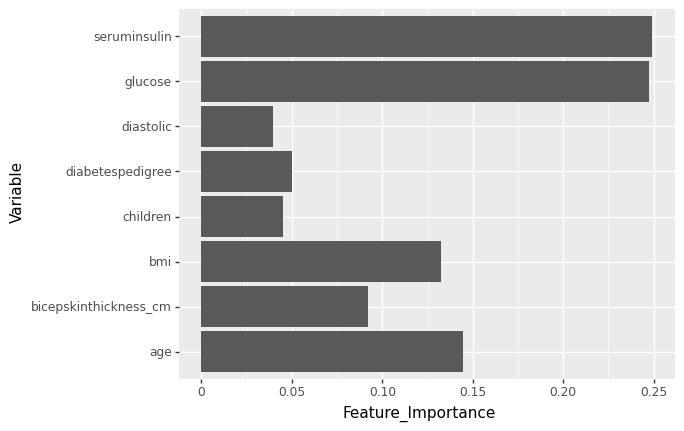

<ggplot: (-9223363247974325998)>

In [0]:
(
    p9.ggplot(
        importances,
        p9.aes(x='Variable', y='Feature_Importance')
    )
    + p9.geom_bar(stat='identity')
    + p9.coord_flip()
)